In [1]:
%load_ext autoreload
%autoreload 2

import mnist
import matplotlib.pyplot as plt
import numpy as np

In [2]:
%matplotlib inline

In [3]:
def print_statistics(conf_true, conf_false):
    print("\t".join(["\tcorrect", "incorrect"]))
    print("median:\t{:.4f}\t{:.4f}".format(np.median(conf_true), np.median(conf_false)))
    print("mean:\t{:.4f}\t{:.4f}".format(np.mean(conf_true), np.mean(conf_false)))
    print("size:\t{}\t{}".format(len(conf_true), len(conf_false)))

## Notebook description

Estimating a deep model prediction confidence is an important part of a product in which the model is deployed.
In case of a classification task, a naive approach of using softmax of the class scores as likelihood estimation may produce over-confident models (i.e. the confidence of the prediction is disproportionally high) [1].
In this notebook, a method for estimating prediction confidence is presented.
The heteroscedastic aleatoric uncertainty presented in [2] (see section 2.2) is used for confidence estimation.
There is a well written blog-post about this paper by the first author, https://alexgkendall.com/computer_vision/bayesian_deep_learning_for_safe_ai/.


[1] On Calibration of Modern Neural Networks, Chuan Guo et al, https://arxiv.org/pdf/1706.04599.pdf
[2] What Uncertainties Do We Need in Bayesian Deep Learning for Computer Vision?, Alex Kendall, Yarin Gal https://arxiv.org/pdf/1703.04977.pdf

## Plain CNN without confidence prediction

In [4]:
model = mnist.Model(predict_confidence=False, num_epochs=15)
model.train()
model.test_accuracy()

Optimizing model...
Epoch 1/15:
Validation loss = 0.1837, Validation accuracy = 0.961
Epoch 2/15:
Validation loss = 0.1119, Validation accuracy = 0.973
Epoch 3/15:
Validation loss = 0.0886, Validation accuracy = 0.978
Epoch 4/15:
Validation loss = 0.0790, Validation accuracy = 0.979
Epoch 5/15:
Validation loss = 0.0680, Validation accuracy = 0.982
Epoch 6/15:
Validation loss = 0.0646, Validation accuracy = 0.983
Epoch 7/15:
Validation loss = 0.0663, Validation accuracy = 0.983
Epoch 8/15:
Validation loss = 0.0697, Validation accuracy = 0.983
Epoch 9/15:
Validation loss = 0.0674, Validation accuracy = 0.983
Epoch 10/15:
Validation loss = 0.0645, Validation accuracy = 0.984
Epoch 11/15:
Validation loss = 0.0641, Validation accuracy = 0.984
Epoch 12/15:
Validation loss = 0.0644, Validation accuracy = 0.985
Epoch 13/15:
Validation loss = 0.0669, Validation accuracy = 0.985
Epoch 14/15:
Validation loss = 0.0610, Validation accuracy = 0.985
Epoch 15/15:
Validation loss = 0.0677, Validation a

In [5]:
pred, correct, _ = model.predict_test(10000)

In [6]:
conf_true = np.max(pred[correct], axis=1)
conf_false = np.max(pred[~correct], axis=1)

In [7]:
print_statistics(conf_true, conf_false)

	correct	incorrect
median:	1.0000	0.8235
mean:	0.9963	0.8065
size:	9855	145


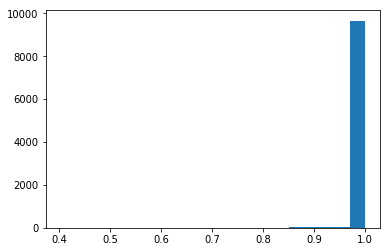

In [8]:
ax = plt.hist(std_true, 20)

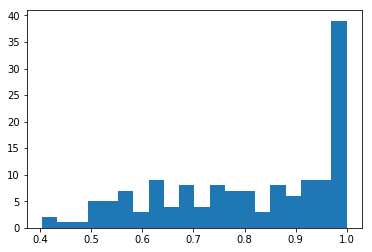

In [9]:
ax = plt.hist(std_false, 20)

Figures above show that indeed, a naive method of confidence estimation is uncalibrated.
Also, note that median for incorrect classifications is $0.8235$: half of incorrect predictions have confidence greater than $0.8235$. On the correct predictions, the confidence is clearly biased.

## CNN with confidence estimation

In [10]:
model = mnist.Model(predict_confidence=True, num_epochs=15)
model.train()
model.test_accuracy()

Optimizing model...
Epoch 1/15:
Validation loss = -0.2492, Validation accuracy = 0.965
Epoch 2/15:
Validation loss = -0.6072, Validation accuracy = 0.975
Epoch 3/15:
Validation loss = -0.6951, Validation accuracy = 0.979
Epoch 4/15:
Validation loss = -0.8071, Validation accuracy = 0.981
Epoch 5/15:
Validation loss = -0.7248, Validation accuracy = 0.975
Epoch 6/15:
Validation loss = -0.8500, Validation accuracy = 0.984
Epoch 7/15:
Validation loss = -0.8235, Validation accuracy = 0.984
Epoch 8/15:
Validation loss = -0.7892, Validation accuracy = 0.986
Epoch 9/15:
Validation loss = -0.5731, Validation accuracy = 0.977
Epoch 10/15:
Validation loss = -0.7946, Validation accuracy = 0.984
Epoch 11/15:
Validation loss = -0.5825, Validation accuracy = 0.985
Epoch 12/15:
Validation loss = 1.5784, Validation accuracy = 0.977
Epoch 13/15:
Validation loss = 0.0779, Validation accuracy = 0.987
Epoch 14/15:
Validation loss = 1.1225, Validation accuracy = 0.983
Epoch 15/15:
Validation loss = 0.2705, V

In [11]:
pred, correct, std_dev = model.predict_test(10000)

In [12]:
# estimation of standard deviation
std_true = std_dev[correct]
std_false = std_dev[~correct]

In [13]:
print_statistics(std_true, std_false)

	correct	incorrect
median:	0.0188	0.0936
mean:	0.0337	0.1100
size:	9857	143


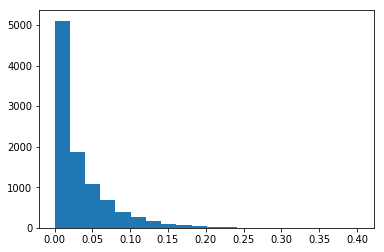

In [14]:
ax = plt.hist(std_true, 20)

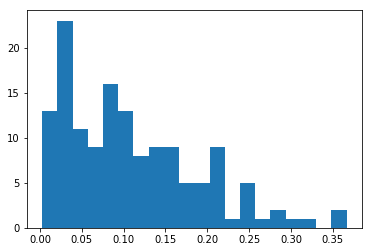

In [15]:
ax = plt.hist(std_false, 20)

Using heteroscedastic aleatoric uncertainty for (anti)-confidence estimation produces more balanced results. The model is still highly confident for the correct samples, and the uncertainty is higher for the incorrect samples.

The accuracy of the modified model does not seem to be affected by introducing uncertainty estimation.